In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utilas.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

from BayesLeNet5 import BayesLeNet5

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = MNIST(
    root="data", 
    download=True, 
    transform=transforms.ToTensor()
)
val_dataset = MNIST(
    root="data", 
    download=True, 
    train=False, 
    transform=transforms.ToTensor()
)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=32, 
    shuffle=True
)
val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=256, 
    shuffle=False
)

model = BayesLeNet5()
model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-4, 
    weight_decay=1e-4
)
criterion = torch.nn.CrossEntropyLoss(reduction="sum")

In [3]:
def validate(data_loader, model):
    model.eval()
    
    correct = 0
    pbar = tqdm(total=len(data_loader), desc="Validation", leave=False)
    with torch.no_grad():
        for input, target in data_loader:
            input = input.to(device)
            target = target.to(device)

            output = model(input)
            _, labels = output.max(1)
            
            correct += labels.eq(target).sum()
            pbar.update(1)
        pbar.close()
            
    return correct * 100 / len(data_loader.dataset)

def train(data_loader, model, criterion, optimizer):
    model.train()
    
    beta = torch.tensor(1.0/len(data_loader)).to(device)
    correct = 0
    nlls = []
    kls = []
    pbar = tqdm(total=len(data_loader), desc="Loss: 0", leave=False)
    for input, target in train_loader:
        input = input.to(device)
        target = target.to(device)

        output = model(input)
        nll = criterion(output, target)
        kl = model.kl
        elbo = nll + beta*kl
        
        _, labels = output.max(1)
        correct += labels.eq(target).sum().item()
        nlls.append(nll.item())
        kls.append(kl.item())

        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()
        
        pbar.set_description(f"Loss: {elbo.item():.03f}")
        pbar.update(1)
    pbar.close()
        
    return nlls, kls, correct * 100 / len(data_loader.dataset)

In [4]:
if not os.path.exists("./models"):
    os.mkdir("models")

n_epochs = 200
nlls = []
kls = []
train_accs = []
val_accs = []
best_acc = 0
pbar = tqdm(total=n_epochs, desc="Loss: 0 | Accuracy: 0 % [0 %]", leave=False)
for epoch in range(n_epochs):
   
    epoch_nll, epoch_kl, train_acc = train(
        train_loader, model, criterion, optimizer
    )
    val_acc = validate(val_loader, model)
    
    if val_acc >= best_acc:
        best_acc = val_acc
        torch.save({
            'state_dict': model.state_dict(),
            'val_acc': val_acc,
            'train_acc': train_acc,
            'opt_state_dict' : optimizer.state_dict(),
            },
            'models/bayeslenet5.pt'
        )
        
    nlls.append(epoch_nll)
    kls.append(epoch_kl)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    desc = f"Loss: {np.mean(epoch_nll)+np.mean(epoch_kl):.03f} | "
    desc += f"Accuracy: {train_acc:.02f} % [{val_acc:.02f} %]"
    pbar.set_description(desc)
    pbar.update(1)
pbar.close()

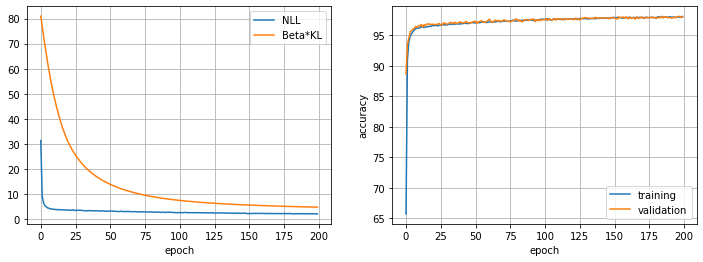

In [5]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(np.mean(nlls, axis=1), label="NLL")
ax[0].plot(np.mean(kls, axis=1)/len(train_loader), label="Beta*KL")
ax[0].set_xlabel("epoch")
ax[0].legend()
ax[0].grid()

ax[1].plot(train_accs, label="training")
ax[1].plot(val_accs, label="validation")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend()
ax[1].grid()

plt.show()